In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
from categoriesDef import categories
cat = categories['high']

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [7]:
dataDir = '../data/cmsRD'
datasets_loc = []

datasets_loc += glob(dataDir + '/ParkingBPH*/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210_CAND.root')

In [8]:
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=1)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210
HLT_Mu12_IP6_part2_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210
HLT_Mu12_IP6_part1_v2 5.27
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210
HLT_Mu12_IP6_part0_v2 5.2
Total lumi: 15.76 fb^-1


In [9]:
tree = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    tree.Add(floc)
print 'N evts: {:.0f}'.format(tree.GetEntries())

N evts: 1737710


# Cuts declaration

In [10]:
cut_general = [
    'n_B == 1',
    'trgMu_pt > ' + str(cat.min_pt),
    'trgMu_pt < ' + str(cat.max_pt),
    'trgMu_sigdxy > ' + str(cat.minIP),
    'fabs(trgMu_eta) < 1.5'
]

# $D_0$ reconstruction

In [11]:
cut_piK = [
####----- Trigger-like cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'fabs(K_eta) < 2.4',
'fabs(pi_eta) < 2.4'
    
# 'cosT_Jpsi_PV > 0.95',
# 'sigdxy_K_PV > 2',
# 'mup_dxy < 2',
]

In [12]:
cut_str = ' && '.join(cut_general + cut_piK)
print cut_str

n_B == 1 && trgMu_pt > 12 && trgMu_pt < 10000.0 && trgMu_sigdxy > 7 && fabs(trgMu_eta) < 1.5 && K_pt > 0.8 && pi_pt > 0.8 && pval_piK > 0.1 && fabs(K_eta) < 2.4 && fabs(pi_eta) < 2.4


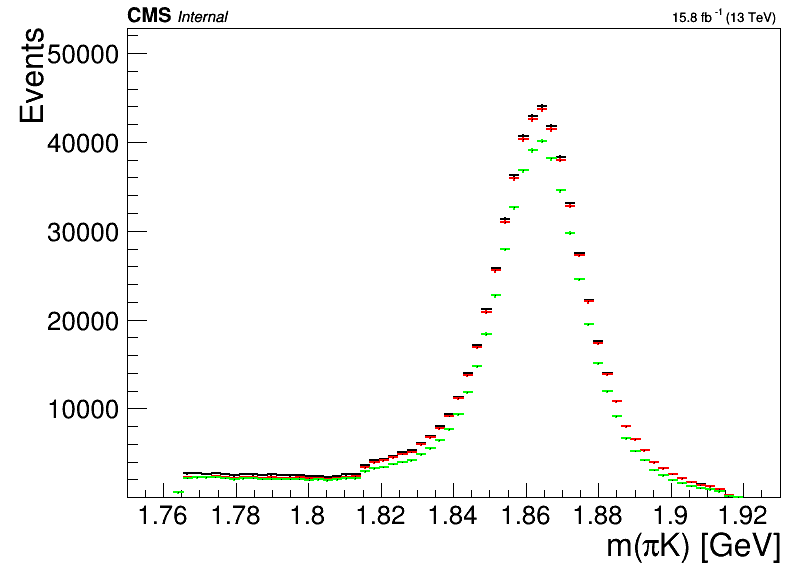

In [13]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#piK) [GeV]', 'Events'],
                binning=[70, 1.75, 1.93]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && D0_refitD0pismu_pt > 5')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tree.Project('h3', 'mass_piK', cut_str + ' && pi_N_valid_hits > 12')
h3.Sumw2()
h3.SetLineColor(rt.kGreen)

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.Draw()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

633772.0


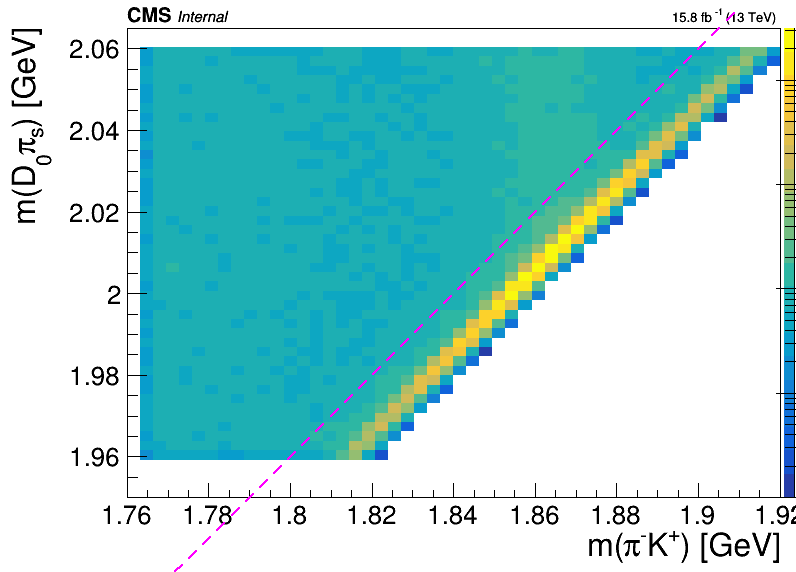

In [14]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'm(D_{0}#pi_{s}) [GeV]', 'Events'],
                binning=[50, 1.76, 1.92, 50, 1.95, 2.065]
               )
tree.Project('h', 'mass_D0pis:mass_piK', cut_str)
h.Sumw2()
print h.GetEntries()
                         
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetLogz()
cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
c.Draw()

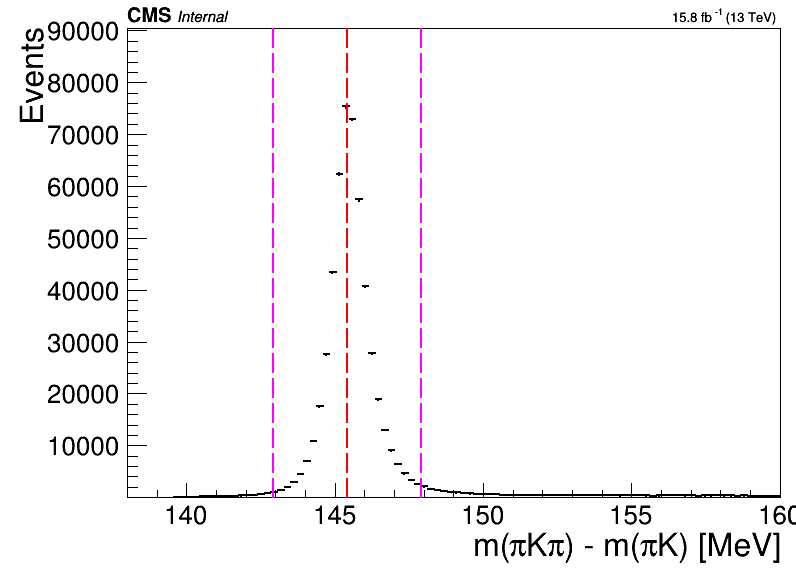

In [15]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#piK#pi) - m(#piK) [MeV]', 'Events'],
                binning=[100, 138, 160]
               )
tree.Project('h', '1e3*(mass_D0pis - mass_piK)', cut_str)
h.Sumw2()

# h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
# tree.Project('h2', 'mass_piK', cut_str + ' && D0_refitD0pismu_pt > 5')
# h2.Sumw2()
# h2.SetLineColor(rt.kRed)

# h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
# tree.Project('h3', 'mass_piK', cut_str + ' && pi_N_valid_hits > 12')
# h3.Sumw2()
# h3.SetLineColor(rt.kGreen)

c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()
cl.SetLineColor(6)
cl.DrawLine(1e3*(m_Dst-m_D0)+2.5, 0, 1e3*(m_Dst-m_D0)+2.5, 1.2*h.GetMaximum())
cl.DrawLine(1e3*(m_Dst-m_D0)-2.5, 0, 1e3*(m_Dst-m_D0)-2.5, 1.2*h.GetMaximum())
cl.SetLineColor(2)
cl.DrawLine(1e3*(m_Dst-m_D0), 0, 1e3*(m_Dst-m_D0), 1.2*h.GetMaximum())
cl.SetLineColor(6)
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

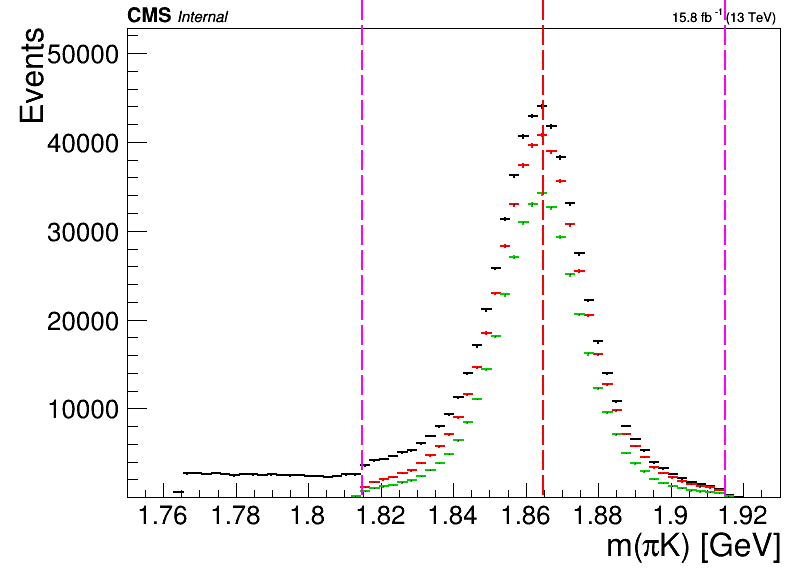

In [16]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#piK) [GeV]', 'Events'],
                binning=[70, 1.75, 1.93]
               )
tree.Project('h', 'mass_piK', cut_str)
h.Sumw2()

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tree.Project('h2', 'mass_piK', cut_str + ' && 1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5')
h2.Sumw2()
h2.SetLineColor(rt.kRed)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tree.Project('h3', 'mass_piK', cut_str + ' && 1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5 && pi_N_valid_hits > 12 && K_N_valid_hits > 12')
h3.Sumw2()
h3.SetLineColor(rt.kGreen+1)

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.Draw()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

cl.SetLineColor(6)
cl.DrawLine(m_D0+0.05, 0, m_D0+0.05, 1.2*h.GetMaximum())
cl.DrawLine(m_D0-0.05, 0, m_D0-0.05, 1.2*h.GetMaximum())
cl.SetLineColor(2)
cl.DrawLine(m_D0, 0, m_D0, 1.2*h.GetMaximum())
cl.SetLineColor(6)

In [17]:
cut_piK += ['1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5', 'abs(mass_piK - 1.864) < 0.05']
cut_piK = list(dict.fromkeys(cut_piK))
cut_piK

['pval_piK > 0.1',
 'K_pt > 0.8',
 'abs(mass_piK - 1.864) < 0.05',
 'fabs(K_eta) < 2.4',
 '1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5',
 'fabs(pi_eta) < 2.4',
 'pi_pt > 0.8']

# $D^*$ Recostruction

In [18]:
cut_D0pis = [
'pis_pt > 0.4',
'fabs(pi_eta) < 2.4',
'sigdxy_pis_PV > 2',
'pval_D0pis > 0.1'
]

In [19]:
cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis)
print cut_str

n_B == 1 && trgMu_pt > 12 && trgMu_pt < 10000.0 && trgMu_sigdxy > 7 && fabs(trgMu_eta) < 1.5 && pval_piK > 0.1 && K_pt > 0.8 && abs(mass_piK - 1.864) < 0.05 && fabs(K_eta) < 2.4 && 1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5 && fabs(pi_eta) < 2.4 && pi_pt > 0.8 && pis_pt > 0.4 && fabs(pi_eta) < 2.4 && sigdxy_pis_PV > 2 && pval_D0pis > 0.1


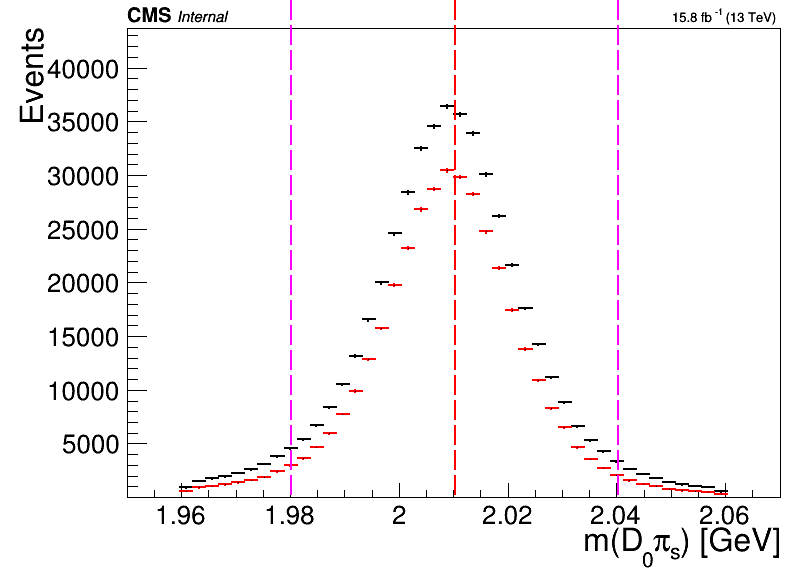

In [20]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(D_{0}#pi_{s}) [GeV]', 'Events'],
                binning=[50, 1.95, 2.07]
               )
tree.Project('h', 'mass_D0pis', cut_str)
h.Sumw2()

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tree.Project('h3', 'mass_D0pis', cut_str + '&& pi_N_valid_hits > 12 && K_N_valid_hits > 12 && pis_N_valid_hits > 0')
h3.Sumw2()
h3.SetLineColor(rt.kRed)

c = drawOnCMSCanvas(CMS_lumi, [h, h3], 'same')
c.Draw()
# c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

cl.SetLineColor(6)
cl.DrawLine(m_Dst+0.03, 0, m_Dst+0.03, 1.2*h.GetMaximum())
cl.DrawLine(m_Dst-0.03, 0, m_Dst-0.03, 1.2*h.GetMaximum())
cl.SetLineColor(2)
cl.DrawLine(m_Dst, 0, m_Dst, 1.2*h.GetMaximum())
cl.SetLineColor(6)

In [21]:
print h.GetEntries()
print h3.GetEntries()

490672.0
384685.0


In [22]:
cut_D0pis += ['abs(mass_D0pis - 2.01) < 0.03']
cut_D0pis = list(dict.fromkeys(cut_D0pis))
print cut_D0pis

['pval_D0pis > 0.1', 'abs(mass_D0pis - 2.01) < 0.03', 'pis_pt > 0.4', 'fabs(pi_eta) < 2.4', 'sigdxy_pis_PV > 2']


# Full analysis

In [23]:
cut_B = [
    'pval_D0pismu > 0.1'
]
print cut_B

cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis + cut_B)

['pval_D0pismu > 0.1']


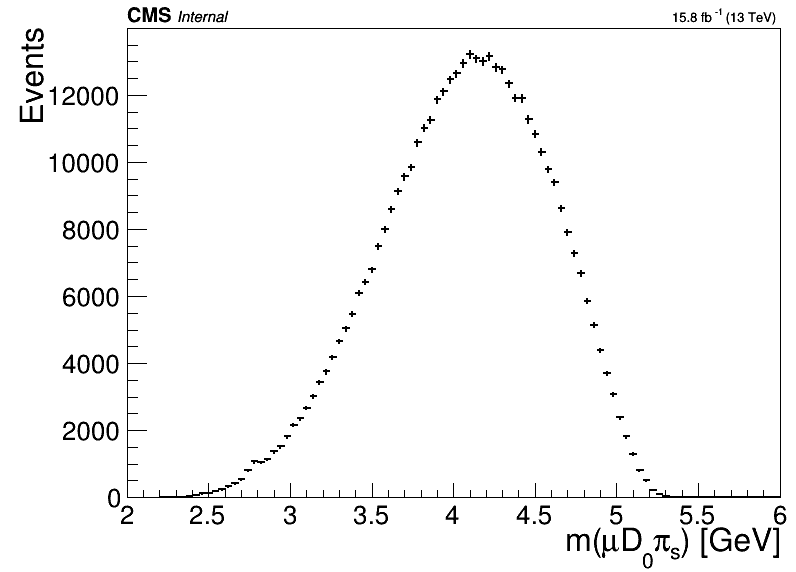

In [24]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#muD_{0}#pi_{s}) [GeV]', 'Events'],
                binning=[100, 2, 6]
               )
tree.Project('h', 'mass_D0pismu', cut_str)
h.Sumw2()
   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()

440245.0


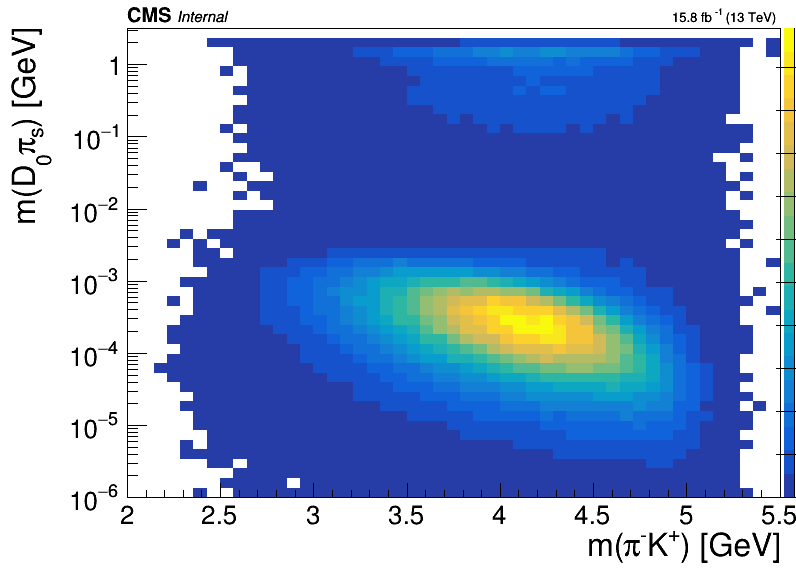

In [25]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'm(D_{0}#pi_{s}) [GeV]', 'Events'],
                binning=[np.linspace(2, 5.5, 50), np.logspace(-6, 0.5, 50)]
               )
tree.Project('h', '1-cos_D0pismu_PV:mass_D0pismu', cut_str)
h.Sumw2()
print h.GetEntries()
                         
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
c.SetLogy()
c.Draw()

440245.0


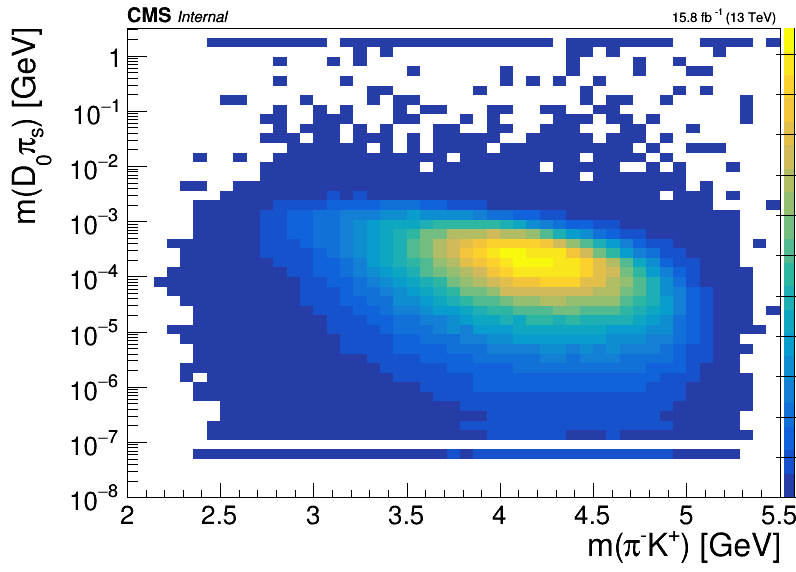

In [26]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['m(#pi^{-}K^{+}) [GeV]', 'm(D_{0}#pi_{s}) [GeV]', 'Events'],
                binning=[np.linspace(2, 5.5, 50), np.logspace(-8, 0.5, 50)]
               )
tree.Project('h', '1-cosT_D0pismu_PV:mass_D0pismu', cut_str)
h.Sumw2()
print h.GetEntries()
                         
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
c.SetLogy()
c.Draw()

In [27]:
cut_B += ['cos_D0pismu_PV > 0.99']
cut_B = list(dict.fromkeys(cut_B))
print cut_B

['pval_D0pismu > 0.1', 'cos_D0pismu_PV > 0.99']


In [28]:
final_cuts = cut_general + cut_piK + cut_D0pis + cut_B
cut_str = ' && '.join(final_cuts)
print '\n'.join(final_cuts)

print cut_str

n_B == 1
trgMu_pt > 12
trgMu_pt < 10000.0
trgMu_sigdxy > 7
fabs(trgMu_eta) < 1.5
pval_piK > 0.1
K_pt > 0.8
abs(mass_piK - 1.864) < 0.05
fabs(K_eta) < 2.4
1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5
fabs(pi_eta) < 2.4
pi_pt > 0.8
pval_D0pis > 0.1
abs(mass_D0pis - 2.01) < 0.03
pis_pt > 0.4
fabs(pi_eta) < 2.4
sigdxy_pis_PV > 2
pval_D0pismu > 0.1
cos_D0pismu_PV > 0.99
n_B == 1 && trgMu_pt > 12 && trgMu_pt < 10000.0 && trgMu_sigdxy > 7 && fabs(trgMu_eta) < 1.5 && pval_piK > 0.1 && K_pt > 0.8 && abs(mass_piK - 1.864) < 0.05 && fabs(K_eta) < 2.4 && 1e3*fabs(mass_D0pis - mass_piK - 0.14543) < 2.5 && fabs(pi_eta) < 2.4 && pi_pt > 0.8 && pval_D0pis > 0.1 && abs(mass_D0pis - 2.01) < 0.03 && pis_pt > 0.4 && fabs(pi_eta) < 2.4 && sigdxy_pis_PV > 2 && pval_D0pismu > 0.1 && cos_D0pismu_PV > 0.99


In [29]:
tree.GetEntries(cut_str)

390515L